#### task 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product

<div style="color: green; font-weight:
bold">
<ul>
<li>Solution code handled if the number of layers is less than 2, which we didn't</li>
<li>Overall, our code is better as it more generalized becuase it has lesser computations inside the for loop</li>
<li>Also, instead of manually mirroring the decoder layers, we are reversing the encoder layer, which is simpler in coding and computation</li>
</ul>
</div>

In [ ]:
# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        self.encoder = self._build_layer(input_size, bottleneck_size, hidden_size, layers)
        self.decoder = self._build_layer(bottleneck_size, input_size, hidden_size, layers, reverse=True)

    def _build_layer(self, input_dim, output_dim, hidden_size, layers, reverse=False):
        layer_list = []
        # Input layer
        layer_list.append(nn.Linear(input_dim, hidden_size))
        layer_list.append(nn.ReLU())

        # Hidden layers
        for _ in range(layers - 1):
            layer_list.append(nn.Linear(hidden_size, hidden_size))
            layer_list.append(nn.ReLU())

        # Output layer
        layer_list.append(nn.Linear(hidden_size, output_dim))
        return nn.Sequential(*layer_list)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

<div style="color: green; font-weight:
bold">
One thing that solution code did better here was scaling of data, which we missed in task 1
</div>

In [ ]:
def generate_moons(noise=0.1, n_samples=1000):
    data, _ = make_moons(n_samples=n_samples, noise=noise)
    return torch.tensor(data, dtype=torch.float32)

<div style="color: green; font-weight:
bold">
<ul>
<li>Sample solution gave the visualization of how the synthetic data looks compared to original data. We used heatmaps and box to represent loss. The scatter plot is really good for vialization where as we believe heatmaps and boxplot gives more concerete information.</li>
<li>We generated seperate data for train and test, while sample solution splitted the one generated data which is better to ensure that training and testing share same distribution.</li>
<li>The sample solution considers that there are 3 hyperparameters to tune: layers, hidden size and epochs. However, we understood from the complete problem statement that there are 5 hyperparameters to tune, layers, hidden size, epochs, learning rate and sample size.</li>
<li>Sample solution does not test the hyperparamters independent while reconstruction error is dependent of the combined values of different hyperparamteters. Expecially for layers and hidden size. We ensured this testing.</li>
</ul>
</div>

Running hyperparameter study...


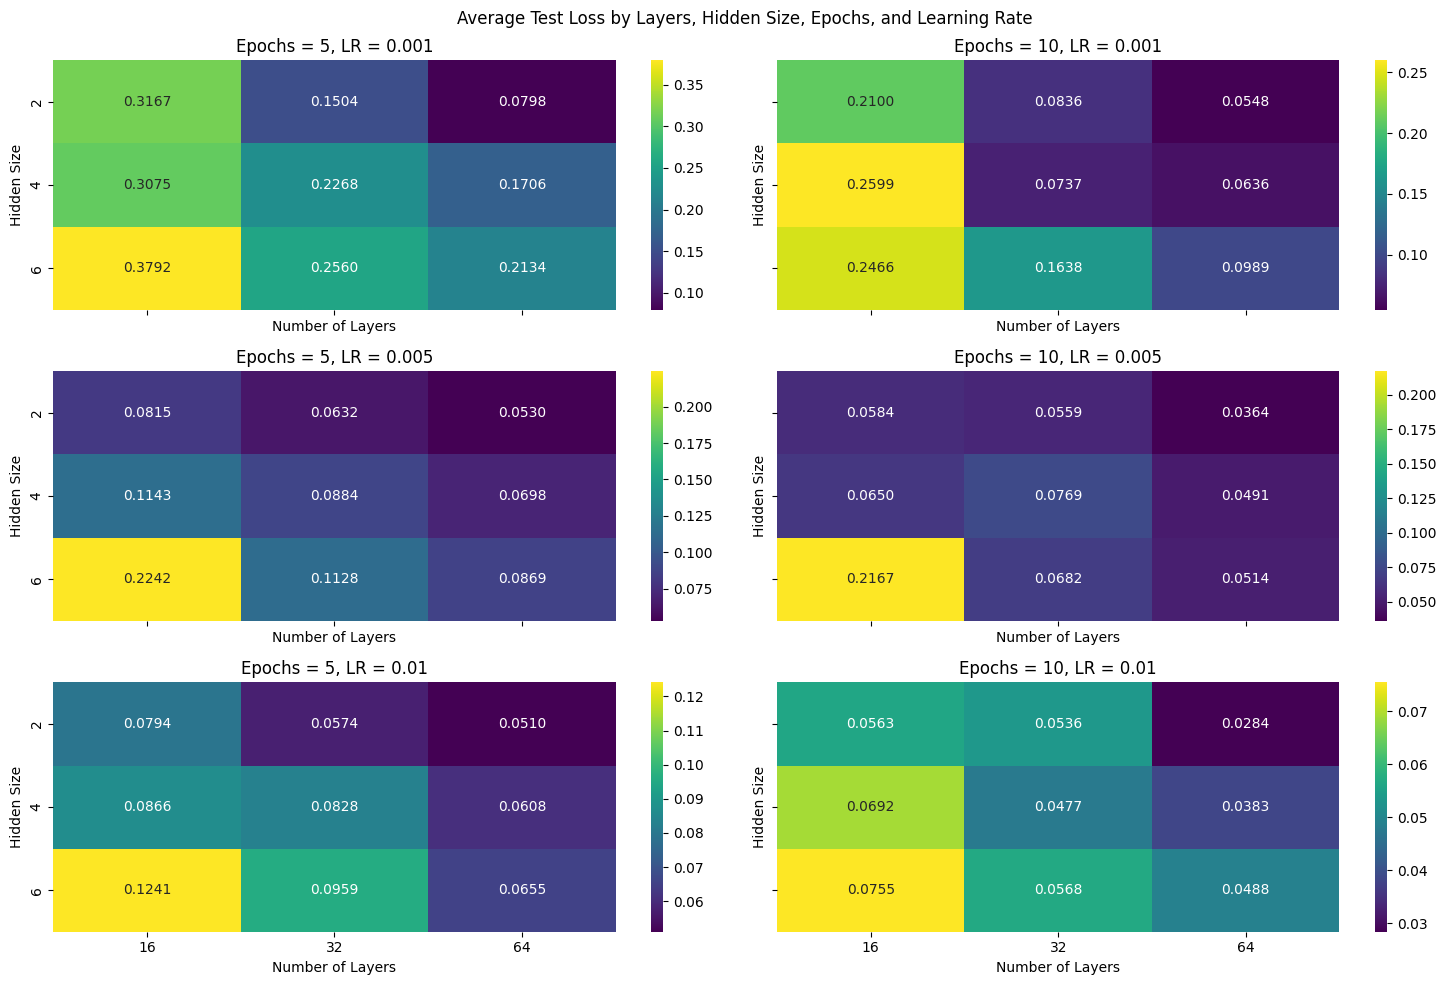

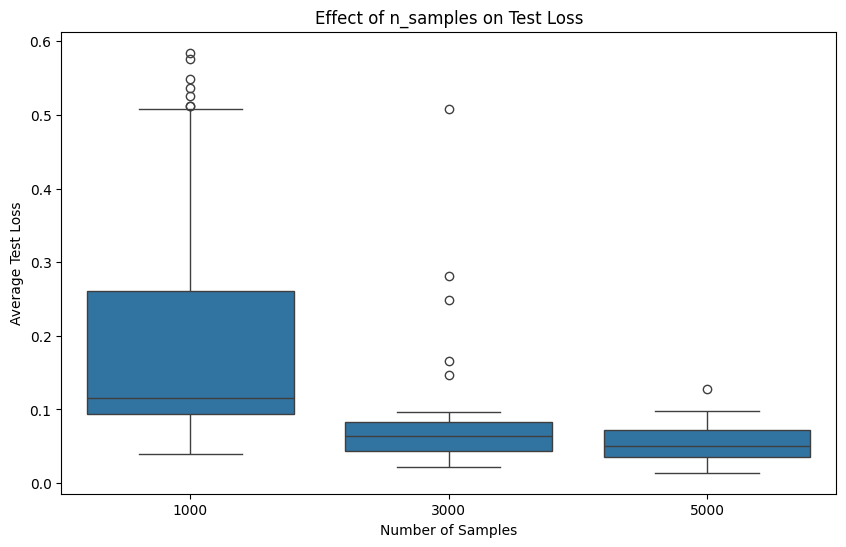


Best parameters: {'hidden_size': 64.0, 'layers': 2.0, 'lr': 0.01, 'epochs': 10.0, 'n_samples': 5000.0, 'final_train_loss': 0.01542477342300117, 'final_test_loss': 0.01413296815007925}


In [ ]:
# 1.1: Systematic investigation of hyperparameters

def train_and_evaluate(model, train_data, test_data, epochs, batch_size=64, lr=0.001):
    """Training function with tracking of train and test losses"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        # Testing
        model.eval()
        with torch.no_grad():
            test_reconstructed = model(test_data)
            test_loss = criterion(test_reconstructed, test_data)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

def hyperparameter_study():

    # Hyperparameter grid
    hidden_sizes = [16, 32, 64]
    layer_counts = [2, 4, 6]
    epochs_list = [5, 10]
    learning_rates = [0.001, 0.005 ,0.01]
    n_samples_list = [1000, 3000, 5000]

    results = []


    for hidden_size, layers, lr, epochs, n_samples in product(hidden_sizes, layer_counts, learning_rates, epochs_list, n_samples_list):

        train_data = generate_moons(noise=0.1, n_samples=int(n_samples * 0.5)) #50% for training
        test_data = generate_moons(noise=0.1, n_samples=int(n_samples * 0.5))

        model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=layers)
        train_losses, test_losses = train_and_evaluate(model, train_data, test_data, epochs, lr=lr)

        results.append({
            'hidden_size': hidden_size,
            'layers': layers,
            'lr': lr,
            'epochs': epochs,
            'n_samples': n_samples,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1]
        })

    # Create visualization
    results_df = pd.DataFrame(results)

    fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(15, 10), sharey=True, sharex=True)
    fig.suptitle("Average Test Loss by Layers, Hidden Size, Epochs, and Learning Rate")

    for i, lr in enumerate(learning_rates):
        for j, epochs in enumerate(epochs_list):

            subset = results_df[(results_df['lr'] == lr) & (results_df['epochs'] == epochs)]


            aggregated_results = []
            for hidden_size in hidden_sizes:
                for layers in layer_counts:
                    subsubset = subset[(subset['hidden_size'] == hidden_size) & (subset['layers'] == layers)]
                    avg_test_loss = subsubset['final_test_loss'].mean()
                    aggregated_results.append({
                        'hidden_size': hidden_size,
                        'layers': layers,
                        'avg_test_loss': avg_test_loss
                    })

            aggregated_results_df = pd.DataFrame(aggregated_results)

            sns.heatmap(
                data=aggregated_results_df.pivot(index='layers', columns='hidden_size', values='avg_test_loss'),
                annot=True, fmt=".4f", cmap="viridis", ax=axes[i, j]
            )
            axes[i, j].set_xlabel("Number of Layers")
            axes[i, j].set_ylabel("Hidden Size")
            axes[i, j].set_title(f"Epochs = {epochs}, LR = {lr}")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='n_samples', y='final_test_loss', data=results_df)
    plt.title('Effect of n_samples on Test Loss')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Test Loss')
    plt.show()

    return results_df

if __name__ == "__main__":

    print("Running hyperparameter study...")
    results_df = hyperparameter_study()
    best_params = results_df.loc[results_df['final_test_loss'].idxmin()].to_dict()
    print("\nBest parameters:", best_params)

##### Observed trends with hyperparameters:

- **Number of Layers:** Increasing the number of layers led to a decrease in the test loss, indicating better model performance. best = 64

- **hidden size:** However, increasing the hidden size, led to increase in the test loss. best = 2

- **Learning Rate:** The learning rate had a noticeable impact on the model's convergence. moving from 0.001 to 0.005 made a significant decrease in the test loss. best = 0.01

- **Epochs:** The number of training epochs also influenced the performance. Higher epoch count resulted in lower test loss. best = 10

- **Number of Samples:** Increase in the number of training samples has improved the model significantly. best 5000





<div style="color: green; font-weight:
bold">
<ul>
<li>Sample solution only tests the variability if for one scenerio. However, we tested for both scenerios.</li>
<li>Also sample solution only displays scatter plots for viasualization. However, we displayed the scatter plots and box plot to represent the statistical measurements.</li>
<li>Sample solution did 6 experiments while we did 5, so that doesn't make much of difference.</li>
<li>Given that, the sample solution, and we handled this task almost in different ways, it is hard to comment that who coded it better. However, we believe that overall we have handled this task better.</li>
</ul>
</div>


Analyzing reconstruction variation...


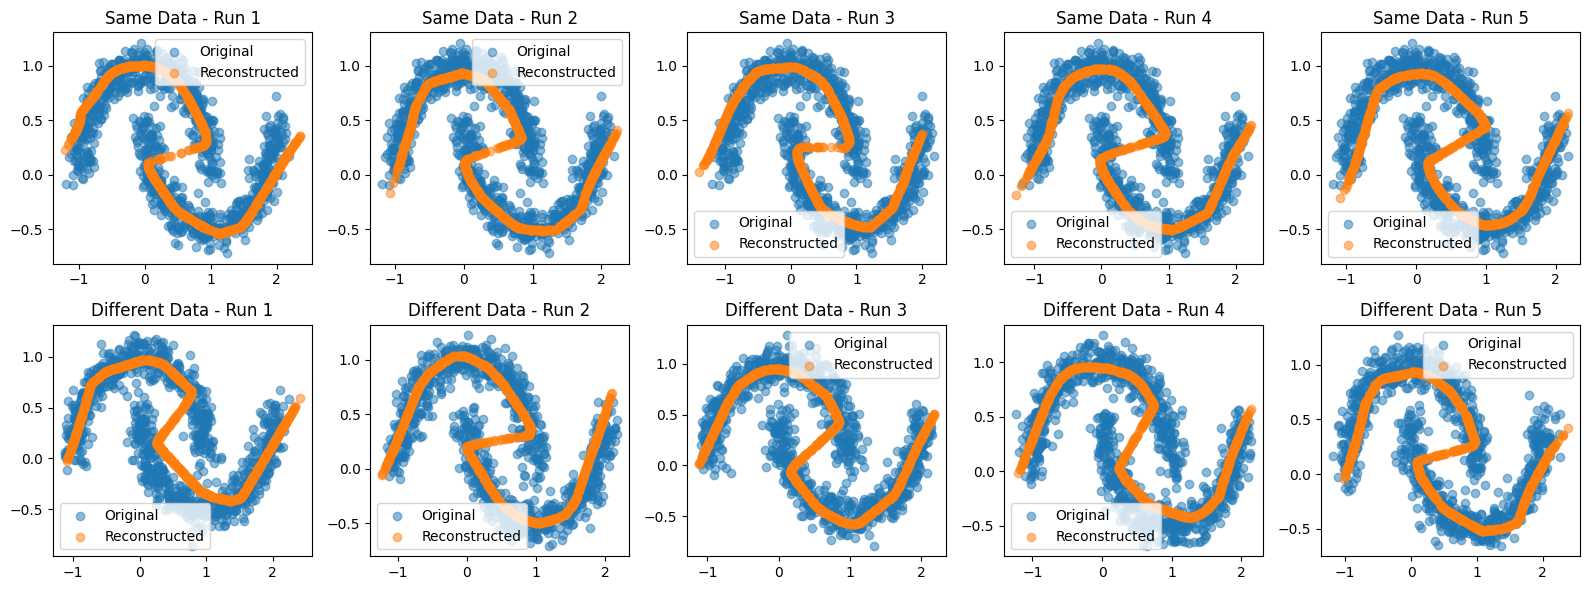

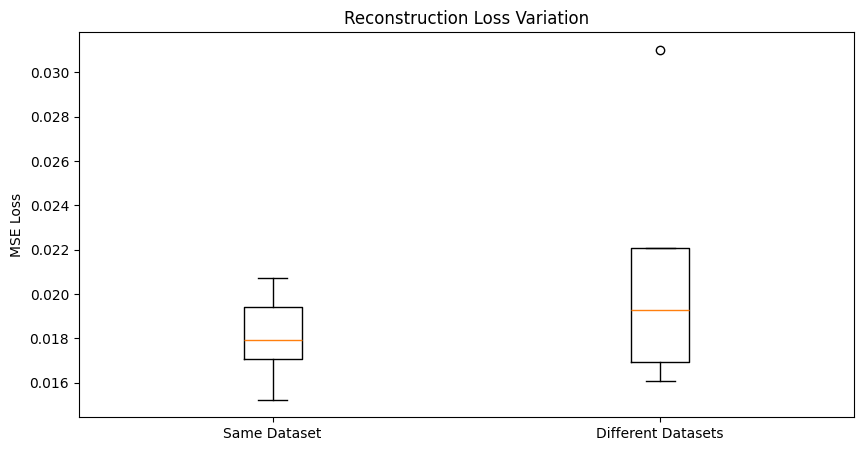

In [ ]:
# Task 1.2: Investigation of reconstruction variation


def reconstruction_variation_study(best_params, runs=5):
    """Study variation in reconstruction for same/different datasets"""
    same_data_losses = []
    diff_data_losses = []

    # Original dataset
    original_data = generate_moons(noise=0.1, n_samples=1000)
    criterion = nn.MSELoss()

    plt.figure(figsize=(16, 6))
    plot_idx = 1

    # Same dataset runs
    for run in range(runs):
        model = Autoencoder(input_size=2, bottleneck_size=1,
                          hidden_size=int(best_params['hidden_size']),
                          layers=int(best_params['layers']))

        train_losses, _ = train_and_evaluate(model, original_data, original_data,
                                           epochs=20, lr=best_params['lr'])

        model.eval()
        with torch.no_grad():
            reconstructed = model(original_data)
            loss = criterion(reconstructed, original_data).item()
            same_data_losses.append(loss)

        # Plot reconstruction
        plt.subplot(2, runs, plot_idx)
        plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.5, label='Original')
        plt.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5, label='Reconstructed')
        plt.title(f'Same Data - Run {run+1}')
        plt.legend()
        plot_idx += 1

    plot_idx = 1
    # Different dataset runs
    for run in range(runs):
        new_data = generate_moons(noise=0.1, n_samples=1000)
        model = Autoencoder(input_size=2, bottleneck_size=1,
                          hidden_size=int(best_params['hidden_size']),
                          layers=int(best_params['layers']))

        train_losses, _ = train_and_evaluate(model, new_data, new_data,
                                           epochs=20, lr=best_params['lr'])

        model.eval()
        with torch.no_grad():
            reconstructed = model(new_data)
            loss = criterion(reconstructed, new_data).item()
            diff_data_losses.append(loss)


        plt.subplot(2, runs, runs + plot_idx)
        plt.scatter(new_data[:, 0], new_data[:, 1], alpha=0.5, label='Original')
        plt.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5, label='Reconstructed')
        plt.title(f'Different Data - Run {run+1}')
        plt.legend()
        plot_idx += 1

    plt.tight_layout()
    plt.show()

    # Plot loss distributions
    plt.figure(figsize=(10, 5))
    plt.boxplot([same_data_losses, diff_data_losses], labels=['Same Dataset', 'Different Datasets'])
    plt.title('Reconstruction Loss Variation')
    plt.ylabel('MSE Loss')
    plt.show()

    return same_data_losses, diff_data_losses



if __name__ == "__main__":
  print("\nAnalyzing reconstruction variation...")
  same_losses, diff_losses = reconstruction_variation_study(best_params)


#### **Observations:**

- Same Dataset: The reconstruction error on the same dataset showed high variation across different training runs. This suggests that the the model's performance can vary depending on the specific random initialization and training process.

- Different Datasets: When trained on different datasets, the reconstruction error exhibited lower variation compared to the same dataset scenario. This indicates that the model is sensitive to the underlying data distribution.

Overall, the analysis revealed that there is some degree of variation in the reconstruction depending on the data and the specific training instance. This information is crucial for understanding the model's reliability and how it might perform on unseen data.


<div style="color: green; font-weight:
bold">
<ul>
<li>Histogram with density normalization is easier for interpretation. Sample solution missed this.</li>
<li>For GMM, n_components=2 is much better than n_components=10.</li>
<li>The programming is straight forward as per the task, so the computation is almost same. Sample solution is more to the point while our solution is more dynamic.</li>
</ul>
</div>


Analyzing latent space...


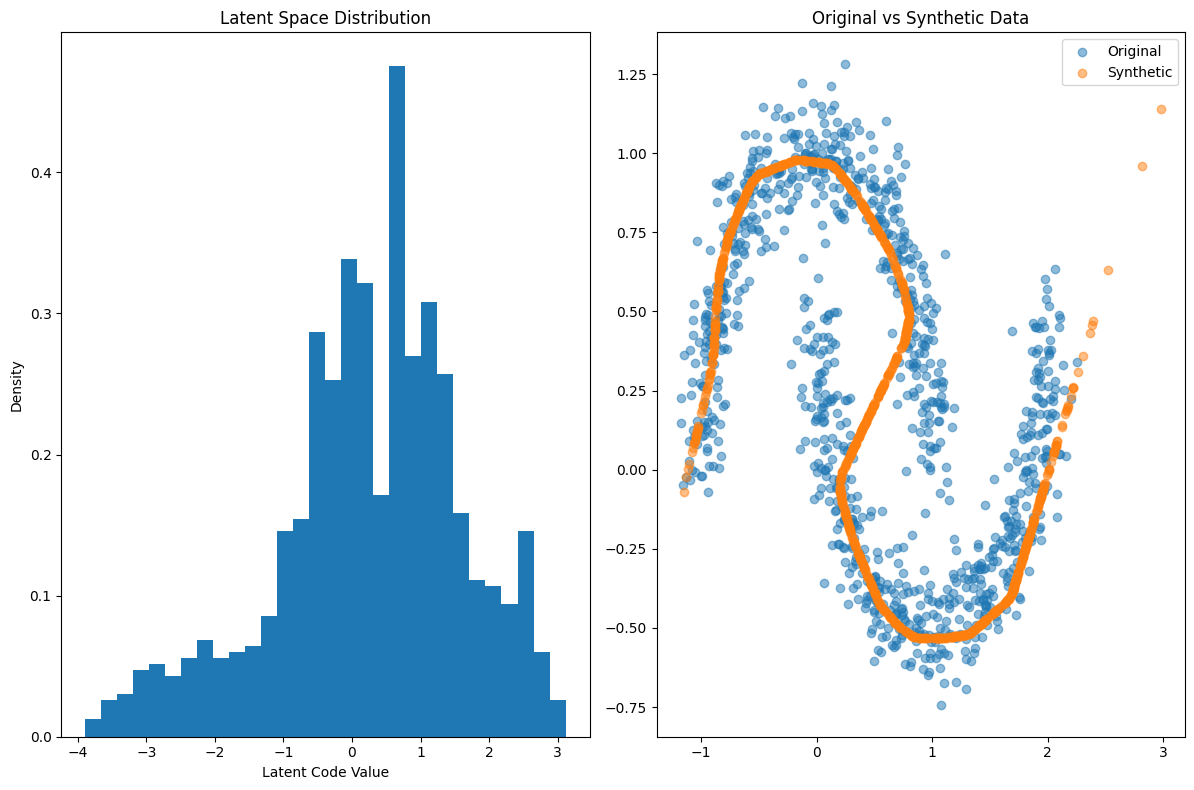

In [ ]:
# Task 1.3: Analysis of latent space

def analyze_latent_space(best_params):
    """Analyze latent space distribution and generate synthetic data"""

    data = generate_moons(noise=0.1, n_samples=1000)
    model = Autoencoder(input_size=2, bottleneck_size=1,
                       hidden_size=int(best_params['hidden_size']),
                       layers=int(best_params['layers']))
    train_and_evaluate(model, data, data, epochs=20, lr=best_params['lr'])


    model.eval()
    with torch.no_grad():
        latent_codes = model.encoder(data).numpy()

    # Histogram
    plt.figure(figsize=(18, 8))

    plt.subplot(131)
    plt.hist(latent_codes, bins=30, density=True)
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Code Value')
    plt.ylabel('Density')

    # Fitting GMM and generate synthetic data
    gmm = GaussianMixture(n_components=2)
    gmm.fit(latent_codes)
    synthetic_codes = gmm.sample(1000)[0]

    # Synthetic data
    with torch.no_grad():
        synthetic_data = model.decoder(torch.tensor(synthetic_codes, dtype=torch.float32)).numpy()

    # Plot original vs synthetic
    plt.subplot(132)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original')
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, label='Synthetic')
    plt.title('Original vs Synthetic Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

print("\nAnalyzing latent space...")
model = analyze_latent_space(best_params)

#### Quality of generated Data

- Visual comparison of the generated synthetic data with the original dataset reveals that the autoencoder, demonstrates a good ability to generate new data points resembling the original distribution.

- The generated data exhibit similar characteristics to the real data, capturing key features and patterns. This suggests that the autoencoder has learned a meaningful and representative latent space encoding.



<div style="color: green; font-weight:
bold">
<ul>
<li>Given how direct the task is, both solutions are to the point. The only difference is that sample solution is normalizing the data, which we are given we didn't normalize for training.</li>
<li>We ensured to change model state to evaluation mode, which sample solution missed.</li>
</ul>
</div>


Testing on higher noise levels...


<ipython-input-7-10e24f3c1c50>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed = model(torch.tensor(test_data, dtype=torch.float32))


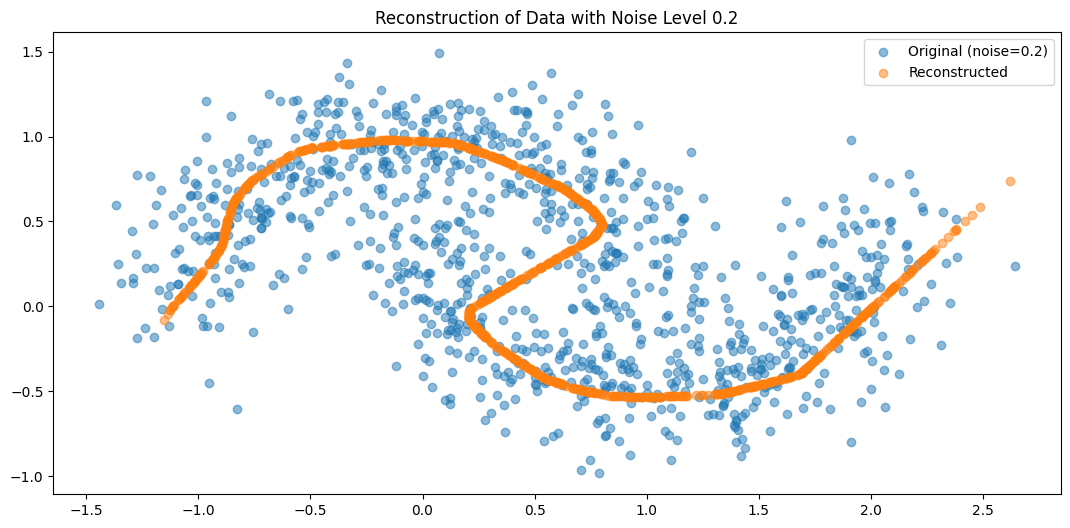

MSE for noise level 0.2: 0.050230


In [ ]:
# Task 1.4: Testing on higher noise levels

def test_high_noise(model, noise_level=0.2):
    """Test model performance on higher noise level"""
    test_data = generate_moons(noise=noise_level, n_samples=1000)

    model.eval()
    with torch.no_grad():
        reconstructed = model(torch.tensor(test_data, dtype=torch.float32))

    # Plot
    plt.figure(figsize=(13, 6))
    plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.5, label=f'Original (noise={noise_level})')
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5, label='Reconstructed')
    plt.title(f'Reconstruction of Data with Noise Level {noise_level}')
    plt.legend()
    plt.show()

    # MSE
    mse = mean_squared_error(test_data, reconstructed.numpy())
    print(f"MSE for noise level {noise_level}: {mse:.6f}")

    return mse


if __name__ == "__main__":
    print("\nTesting on higher noise levels...")
    test_high_noise(model, noise_level=0.2)

Yes, the autoencoder still did a good job at reconstructing the data even with noise level of 0.2

However this has has led to some increase in the error loss. So comparing to the one with noise level of 0.1, this has a weaker model performance.

<div style="color: green; font-weight:
bold">
<ul>
<li>Sample solution is precise as everthing is done calling the methods which as defined and used before. We we did number of steps like from scratch. We could have avoided this.</li>
</ul>
</div>


--- Task 5: Train Autoencoder with Noise Level 0.2 ---


<ipython-input-8-d5daf37c13bc>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data, dtype=torch.float32)
<ipython-input-8-d5daf37c13bc>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data, dtype=torch.float32)


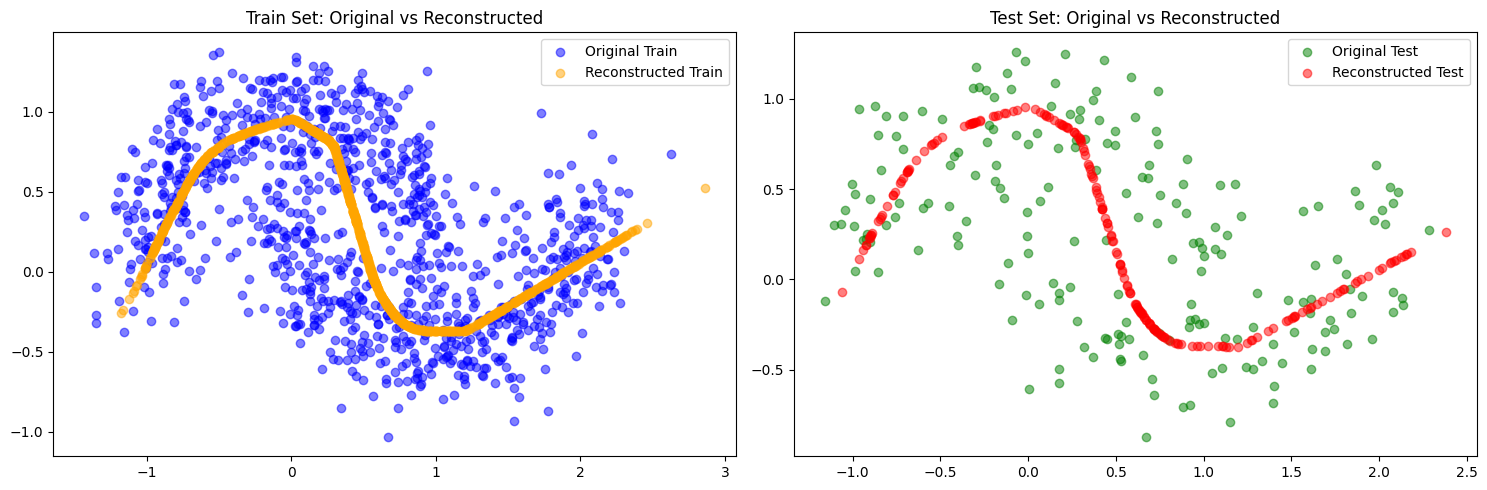

Train MSE with noise level 0.2: 0.0553
Test MSE with noise level 0.2: 0.0560


In [ ]:
# Task 1.5

def train_autoencoder_on_higher_noise(params, noise_level=0.2, n_samples=1000, n_test_samples=200):
    """Train autoencoder on a dataset with higher noise and analyze reconstruction geometry"""
    # Generate high-noise training and test datasets
    train_data = generate_moons(noise=noise_level, n_samples=n_samples)
    test_data = generate_moons(noise=noise_level, n_samples=n_test_samples)

    # Convert datasets to PyTorch tensors
    train_data = torch.tensor(train_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    # Initialize the model
    model = Autoencoder(
        input_size=2,
        bottleneck_size=1,
        hidden_size=int(params['hidden_size']),
        layers=int(params['layers'])
    )

    lr = params.get('lr', 0.001)

    # Train the model using the existing train_and_evaluate function
    train_losses, test_losses = train_and_evaluate(
        model=model,
        train_data=train_data,
        test_data=test_data,
        epochs=int(params['epochs']),
        lr=lr
    )

    # Analyze geometry using the trained model
    model.eval()
    with torch.no_grad():
        reconstructed_train = model(train_data).numpy()
        reconstructed_test = model(test_data).numpy()

    # Plot reconstructed vs original
    plt.figure(figsize=(15, 5))

    # Training set comparison
    plt.subplot(121)
    plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.5, label='Original Train', color='blue')
    plt.scatter(reconstructed_train[:, 0], reconstructed_train[:, 1], alpha=0.5, label='Reconstructed Train', color='orange')
    plt.title('Train Set: Original vs Reconstructed')
    plt.legend()

    # Test set comparison
    plt.subplot(122)
    plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.5, label='Original Test', color='green')
    plt.scatter(reconstructed_test[:, 0], reconstructed_test[:, 1], alpha=0.5, label='Reconstructed Test', color='red')
    plt.title('Test Set: Original vs Reconstructed')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Reconstruction loss
    train_mse = mean_squared_error(train_data, reconstructed_train)
    test_mse = mean_squared_error(test_data, reconstructed_test)
    print(f"Train MSE with noise level {noise_level}: {train_mse:.4f}")
    print(f"Test MSE with noise level {noise_level}: {test_mse:.4f}")

    return model, train_mse, test_mse

if __name__ == "__main__":
    print("\n--- Task 5: Train Autoencoder with Noise Level 0.2 ---")
    # Using best_params from hyperparameter study
    train_autoencoder_on_higher_noise(best_params, noise_level=0.2)

the best parameters show higher relevance to the previously trained model as compared to this.

#### task 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<div style="color: green; font-weight:
bold">
<ul>
<li>For mmd, we used RBF while sample solution has inverse multi-quadratic. While RBF is more robust, inverse multi-quadratic was probably a better choice here because it captures the distributions better.</li>
<li>We used DataLoader for batching which is more efficient.</li>
<li>Sample solution is more simple and direct implementation, while our solution is more modular.</li>
<li>Sample solution is giving better plots of how the data distribution is changing over the parameters, while we are presenting with final plots.</li>
</ul>
</div>

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return x + self.net(x)

class ResNetAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, num_blocks):
        super().__init__()

        # Encoder
        self.encoder_input = nn.Linear(input_size, hidden_size)
        self.encoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.encoder_output = nn.Linear(hidden_size, bottleneck_size)

        # Decoder
        self.decoder_input = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size * 2)
            for _ in range(num_blocks)
        ])
        self.decoder_output = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = self.encoder_input(x)
        for block in self.encoder_blocks:
            h = block(h)
        return self.encoder_output(h)

    def decode(self, z):
        h = self.decoder_input(z)
        for block in self.decoder_blocks:
            h = block(h)
        return self.decoder_output(h)

    def forward(self, x):
        return self.decode(self.encode(x))

def compute_kernel(x, y, bandwidths):
    """
    Compute sum of RBF kernels with different bandwidths
    """
    xx = x.unsqueeze(1)  # (N, 1, D)
    yy = y.unsqueeze(0)  # (1, M, D)
    distances = (xx - yy).pow(2).sum(2)  # (N, M)

    kernels = torch.zeros_like(distances)
    for bandwidth in bandwidths:
        kernels += torch.exp(-distances / (2 * bandwidth ** 2))

    return kernels

def compute_mmd(x, y, bandwidths):
    """
    Compute Maximum Mean Discrepancy between x and y distributions
    """
    x_kernel = compute_kernel(x, x, bandwidths)
    y_kernel = compute_kernel(y, y, bandwidths)
    xy_kernel = compute_kernel(x, y, bandwidths)

    N = x_kernel.size(0)
    M = y_kernel.size(0)

    xx = x_kernel.sum() / (N * (N - 1))  # exclude diagonal
    yy = y_kernel.sum() / (M * (M - 1))  # exclude diagonal
    xy = xy_kernel.mean()

    mmd = xx + yy - 2 * xy
    return mmd

def train_mmd_autoencoder(model, train_loader, test_loader, epochs,
                         lr=0.001, bandwidths=[0.1, 0.2, 0.4, 0.8, 1.6],
                         mmd_weight=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    reconstruction_criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            batch_size = batch_data.size(0)

            optimizer.zero_grad()

            # Forward pass
            codes = model.encode(batch_data)
            reconstructed = model.decode(codes)

            # Compute reconstruction loss
            recon_loss = reconstruction_criterion(reconstructed, batch_data)

            # Compute MMD loss
            reference = torch.randn_like(codes)  # Sample from standard normal
            mmd_loss = compute_mmd(codes, reference, bandwidths)

            # Total loss
            loss = recon_loss + mmd_weight * mmd_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                codes = model.encode(batch_data)
                reference = torch.randn_like(codes)

                recon_loss = reconstruction_criterion(reconstructed, batch_data)
                mmd_loss = compute_mmd(codes, reference, bandwidths)
                loss = recon_loss + mmd_weight * mmd_loss

                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

def generate_samples(model, n_samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, 2).to(device)
        # Generate samples through decoder
        samples = model.decode(z).cpu().numpy()
    return samples

def get_latent_codes(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    latent_codes = []
    original_data = []

    with torch.no_grad():
        for batch_data in data_loader:
            batch_input = batch_data[0].to(device)

            # Encode the batch to get latent codes
            codes = model.encode(batch_input)

            # Convert to numpy and append to lists
            latent_codes.append(codes.cpu().numpy())
            original_data.append(batch_input.cpu().numpy())

    # Concatenate all batches
    latent_codes = np.concatenate(latent_codes, axis=0)
    original_data = np.concatenate(original_data, axis=0)

    return latent_codes, original_data


# Example usage:
def run_mmd_experiment(n_samples=1000, noise=0.1, hidden_size=64, num_blocks=3,
                      epochs=100, batch_size=32, mmd_weight=0.1):
    # Prepare data
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Create model
    model = ResNetAutoencoder(
        input_size=2,
        bottleneck_size=2,
        hidden_size=hidden_size,
        num_blocks=num_blocks
    )

    # Train model
    train_losses, test_losses = train_mmd_autoencoder(
        model,
        train_loader,
        test_loader,
        epochs=epochs,
        mmd_weight=mmd_weight
    )

    # Generate and visualize results
    synthetic_samples = generate_samples(model, n_samples=1000)

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Original data
    ax1.scatter(X_test[:, 0], X_test[:, 1], alpha=0.5)
    ax1.set_title('Original Data')




    # Reconstructions
    model.eval()
    with torch.no_grad():
        reconstructed = model(torch.FloatTensor(X_test).to(model.decoder_output.weight.device))
        reconstructed = reconstructed.cpu().numpy()
    ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], alpha=0.5)
    ax2.set_title('Reconstructions')

    # Generated samples
    ax3.scatter(synthetic_samples[:, 0], synthetic_samples[:, 1], alpha=0.5)
    ax3.set_title('Generated Samples')

    plt.tight_layout()
    plt.show()

    # Extract latent codes for the entire dataset
    latent_codes, original_data = get_latent_codes(model, train_loader)


    plt.figure(figsize=(18, 8))

    plt.subplot(131)
    plt.hist(latent_codes, bins=30, density=True)
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Code Value')
    plt.ylabel('Density')
    plt.show()


    return model, train_losses, test_losses

Epoch [10/100], Train Loss: 0.0351, Test Loss: 0.0398
Epoch [20/100], Train Loss: 0.0349, Test Loss: 0.0394
Epoch [30/100], Train Loss: 0.0348, Test Loss: 0.0391
Epoch [40/100], Train Loss: 0.0337, Test Loss: 0.0363
Epoch [50/100], Train Loss: 0.0342, Test Loss: 0.0379
Epoch [60/100], Train Loss: 0.0333, Test Loss: 0.0370
Epoch [70/100], Train Loss: 0.0330, Test Loss: 0.0356
Epoch [80/100], Train Loss: 0.0341, Test Loss: 0.0385
Epoch [90/100], Train Loss: 0.0332, Test Loss: 0.0376
Epoch [100/100], Train Loss: 0.0338, Test Loss: 0.0375


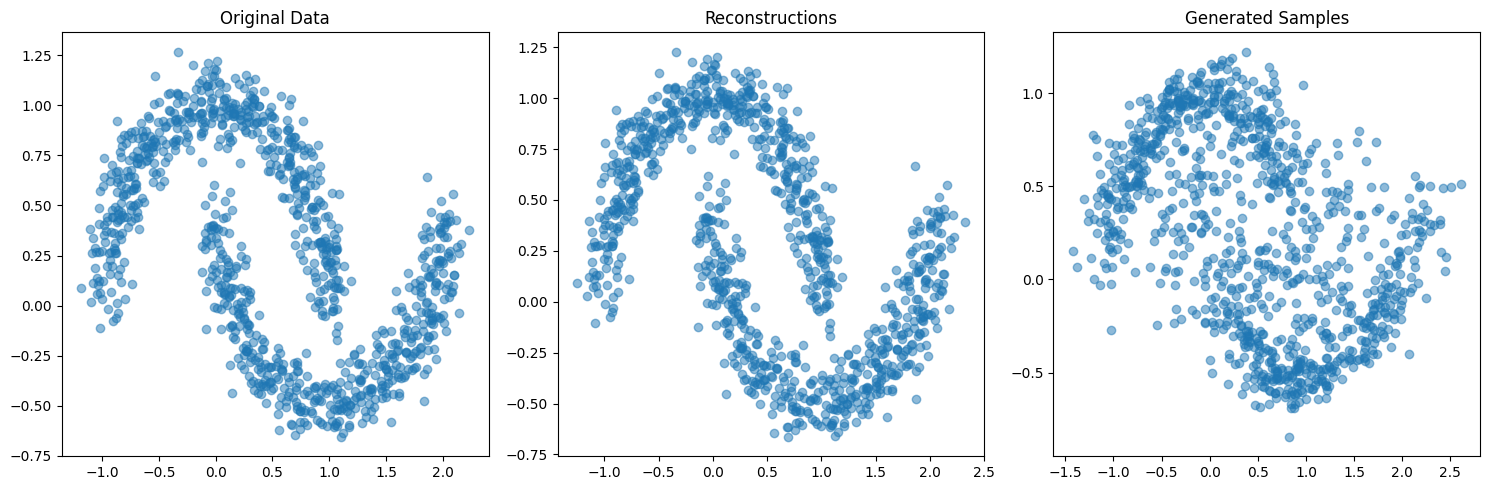

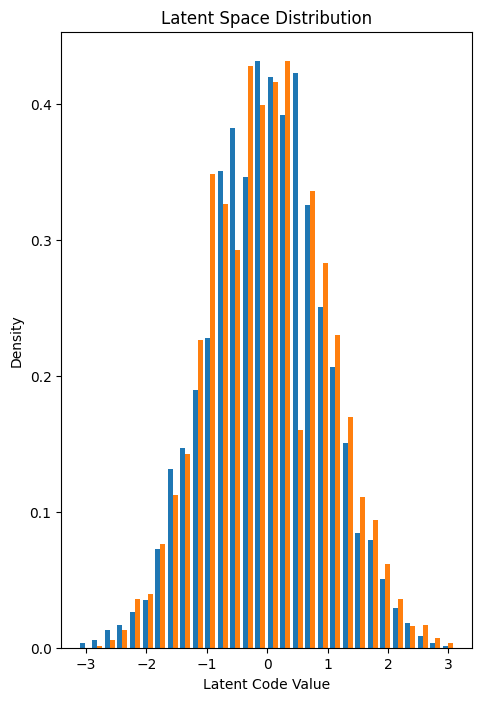

In [ ]:
model, train_losses, test_losses = run_mmd_experiment(
    n_samples=5000,
    noise=0.1,
    hidden_size=64,
    num_blocks=2,
    epochs=100,
    mmd_weight=0.1
)

<!-- We continue with the two mo ons dataset, but this time b ottleneck size 2. Since training now lacks
the regularizing eect of the lossy compression (which enforces the co des to fo cus on the imp ortant
data features), we need an additional loss term. We use the maximum mean discrepancy (MMD)
b etween the co de distribution (i.e. the push-forward through the enco der) and a 2-dimensional
standard normal. This loss pulls the co de distribution towards the standard normal, so that we can
later generate synthetic data by sampling from the standard normal and transform the samples
through the deco der. The kernel for MMD shall b e a sum of squared exp onentials or inverse multi-
quadratics at multiple bandwidths (the numb er and values of the bandwidths are hyp erparameters
 use three to seven bandwidths such that each value is twice the next smaller one). The training
loss is a weighted sum of the squared reconstruction error and the MMD, with the weight b eing yet
another hyp erparameter.
Use the auto enco der from task 1 (with bottleneck_size=2) or implement a residual network (ResNet
 it gave b etter results in our exp eriments). Recall that a ResNet consists of L residual blo cks
computing zl= zl−1 + fl(zl−1) for l = 1, ..., L, where z0 are the original data. The fl() are fully
connected networks with one or two hidden layers whose width is typically larger than the input
dimension. Implement a new function train_mmd_autoencoder() and train the mo del at noise level 0.1.
Visualize the reconstructed vs. original data, and the co de distribution. Check that the reconstruc-
tion error is much less than what you got with a b ottleneck of size 1. Generate synthetic data by
passing standard normal samples through the deco der and visualize their quality. Comment on your


ndings -->

Comparison of the results of the autoencoder with bottleneck size 1 and 2.

- The autoencoder with bottleneck size 2 has a lower reconstruction error than the autoencoder with bottleneck size 1.

- The autoencoder with bottleneck size 2 has a higher capacity to learn the data distribution and can reconstruct the data more accurately.

- The autoencoder with bottleneck size 2 also has a more complex architecture, which allows it to capture more features of the data.

#### task 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

<div style="color: green; font-weight:
bold">
<ul>
<li>Instead of using existing AE model from task 1, we made another.</li>
<li>Sample solution uses StandardScalar for normalization which is more robust than our scaling technique.</li>
<li>Sample solution uses IQR to show spread in data by normalization, which is a very good strategy.</li>
<li>We used DataLoader for batching.</li>
<li>Has run the experiment for different bottleneck sizes as in the sample solution</li>
<li>Has provided plots for latent code distribution & the required logs for the experiments</li>
<li> Our conclusion seems to differ from the sample solution on finding the best bottleneck size.</li>
</ul>
</div>

In [ ]:
class DigitsAutoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()

        # Build encoder
        encoder_layers = []
        # First layer
        encoder_layers.extend([
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        ])

        # Middle layers
        for _ in range(layers - 1):
            encoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])

        # Bottleneck layer
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))

        # Build decoder
        decoder_layers = []
        # First layer from bottleneck
        decoder_layers.extend([
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU()
        ])

        # Middle layers
        for _ in range(layers - 1):
            decoder_layers.extend([
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            ])

        # Output layer
        decoder_layers.append(nn.Linear(hidden_size, input_size))

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

def prepare_digits_data(batch_size=32):
    # Load digits dataset
    digits = load_digits()
    X = digits.data.astype('float32')
    y = digits.target

    # Normalize the data
    X = X / 16.0  # Scale to [0,1]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create dataloaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader, X_train, X_test, y_train, y_test

def train_digits_autoencoder(model, train_loader, test_loader, epochs, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_data in train_loader:
            batch_data = batch_data[0].to(device)
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                batch_data = batch_data[0].to(device)
                reconstructed = model(batch_data)
                loss = criterion(reconstructed, batch_data)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

def visualize_reconstructions(model, X_test, n_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test[:n_samples]).to(device)
        reconstructed = model(X_test_tensor).cpu().numpy()

    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 1.5, 3))
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(X_test[i].reshape(8, 8), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original')

        # Reconstructed
        axes[1, i].imshow(reconstructed[i].reshape(8, 8), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()

def analyze_autoencoder(bottleneck_size, hidden_size=128, layers=2, epochs=100):
    train_loader, test_loader, X_train, X_test, y_train, y_test = prepare_digits_data()

    model = DigitsAutoencoder(64, bottleneck_size, hidden_size, layers)
    train_losses, test_losses = train_digits_autoencoder(model, train_loader, test_loader, epochs)

    visualize_reconstructions(model, X_test)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        reconstructed_test = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    orig_pred = rf.predict(X_test)
    recon_pred = rf.predict(reconstructed_test)

    # Calculate prediction agreement
    agreement = np.mean(orig_pred == recon_pred)
    print(f"\nPrediction agreement between original and reconstructed: {agreement:.2%}")

    # For bottleneck_size=2, visualize latent space
    if bottleneck_size == 2:
        plt.figure(figsize=(10, 8))
        with torch.no_grad():
            latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()
        plt.scatter(latent[:, 0], latent[:, 1], c=y_test, cmap='tab10')
        plt.colorbar(label='Digit')
        plt.title('2D Latent Space')
        plt.xlabel('First Dimension')
        plt.ylabel('Second Dimension')
        plt.show()

    # Generate synthetic data using GMM
    with torch.no_grad():
        latent = model.encode(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(latent)

    # Generate synthetic samples
    synthetic_latent = gmm.sample(n_samples=20)[0]
    with torch.no_grad():
        synthetic_digits = model.decode(torch.FloatTensor(synthetic_latent).to(device)).cpu().numpy()

    # Visualize synthetic digits
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        ax.axis('off')
    plt.suptitle('Synthetic Digits')
    plt.tight_layout()
    plt.show()

    # Classify synthetic data
    synthetic_pred = rf.predict(synthetic_digits)
    print("\nPredicted classes for synthetic digits:", synthetic_pred)

    return model, train_losses, test_losses

# Function to run experiments with different bottleneck sizes
def run_bottleneck_experiments():
    bottleneck_sizes = [2, 4, 8]
    for size in bottleneck_sizes:
        print(f"\nRunning experiment with bottleneck size {size}")
        analyze_autoencoder(size)


Running experiment with bottleneck size 2
Epoch [10/100], Train Loss: 0.0407, Test Loss: 0.0408
Epoch [20/100], Train Loss: 0.0360, Test Loss: 0.0367
Epoch [30/100], Train Loss: 0.0332, Test Loss: 0.0348
Epoch [40/100], Train Loss: 0.0307, Test Loss: 0.0334
Epoch [50/100], Train Loss: 0.0296, Test Loss: 0.0329
Epoch [60/100], Train Loss: 0.0282, Test Loss: 0.0320
Epoch [70/100], Train Loss: 0.0270, Test Loss: 0.0314
Epoch [80/100], Train Loss: 0.0261, Test Loss: 0.0316
Epoch [90/100], Train Loss: 0.0254, Test Loss: 0.0307
Epoch [100/100], Train Loss: 0.0246, Test Loss: 0.0304


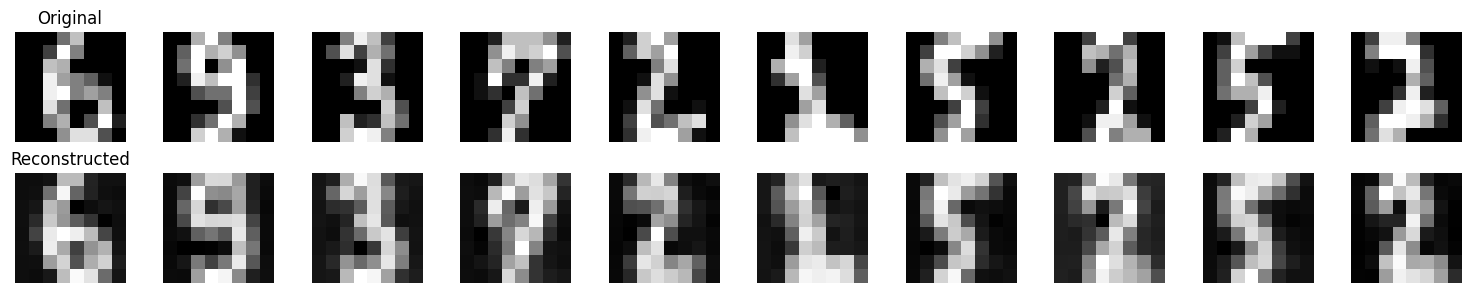


Prediction agreement between original and reconstructed: 87.22%


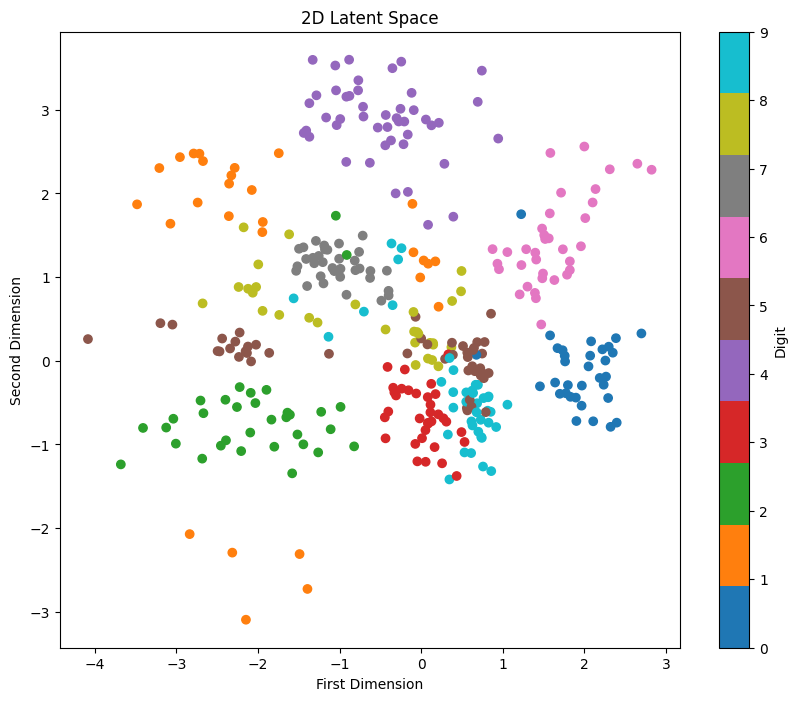

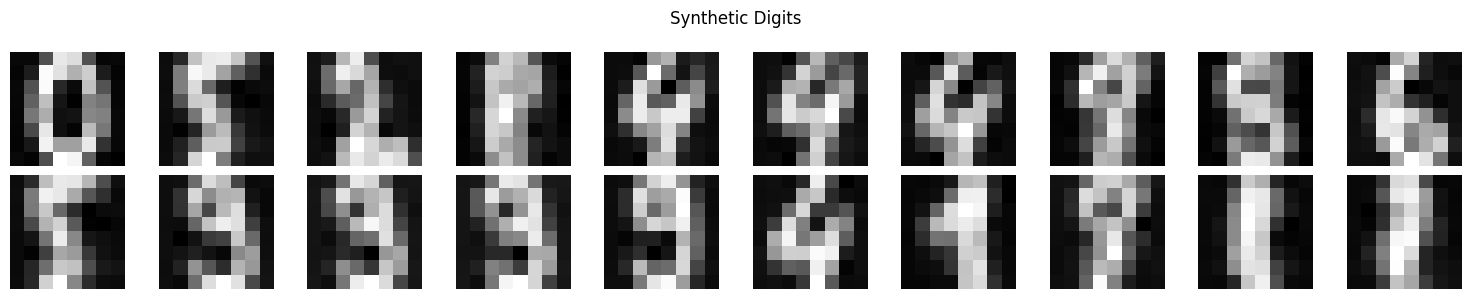


Predicted classes for synthetic digits: [0 5 2 8 4 4 4 8 8 6 5 9 9 9 9 4 1 8 1 1]

Running experiment with bottleneck size 4
Epoch [10/100], Train Loss: 0.0273, Test Loss: 0.0270
Epoch [20/100], Train Loss: 0.0218, Test Loss: 0.0232
Epoch [30/100], Train Loss: 0.0197, Test Loss: 0.0220
Epoch [40/100], Train Loss: 0.0183, Test Loss: 0.0209
Epoch [50/100], Train Loss: 0.0174, Test Loss: 0.0201
Epoch [60/100], Train Loss: 0.0167, Test Loss: 0.0201
Epoch [70/100], Train Loss: 0.0161, Test Loss: 0.0199
Epoch [80/100], Train Loss: 0.0155, Test Loss: 0.0197
Epoch [90/100], Train Loss: 0.0150, Test Loss: 0.0194
Epoch [100/100], Train Loss: 0.0146, Test Loss: 0.0189


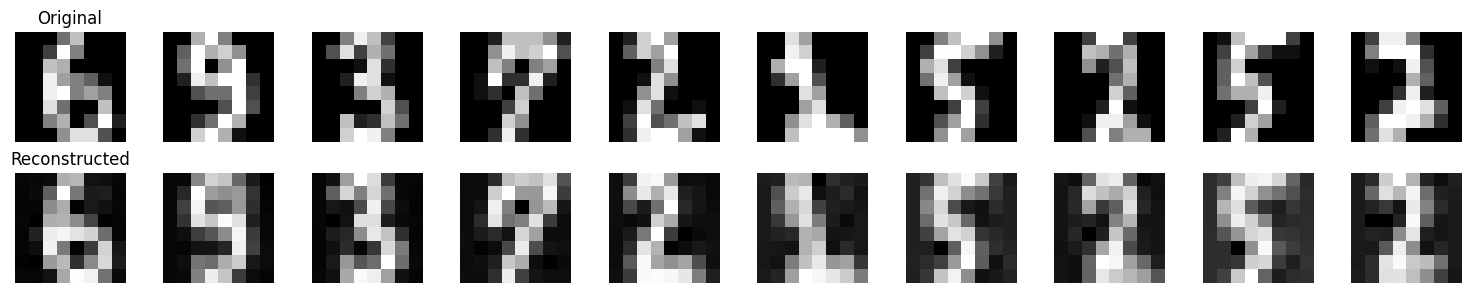


Prediction agreement between original and reconstructed: 94.44%


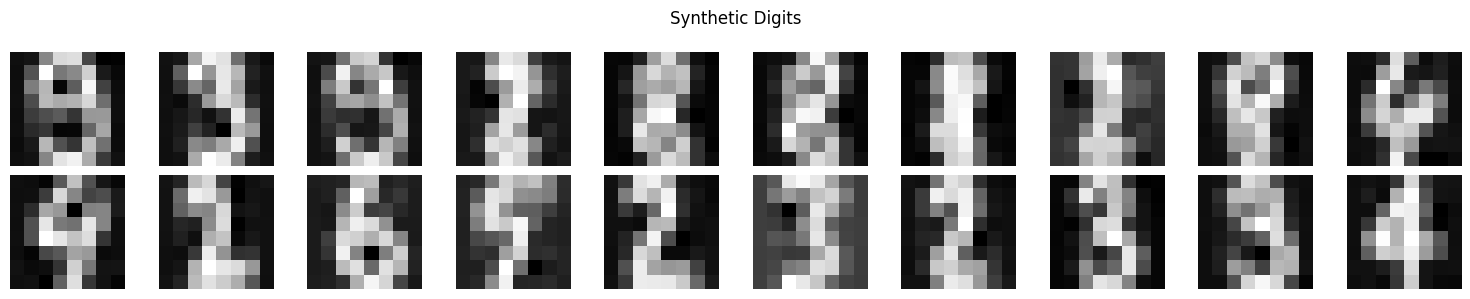


Predicted classes for synthetic digits: [9 3 9 8 8 8 8 2 8 4 4 2 6 5 2 3 2 3 9 4]

Running experiment with bottleneck size 8
Epoch [10/100], Train Loss: 0.0190, Test Loss: 0.0193
Epoch [20/100], Train Loss: 0.0145, Test Loss: 0.0157
Epoch [30/100], Train Loss: 0.0129, Test Loss: 0.0145
Epoch [40/100], Train Loss: 0.0118, Test Loss: 0.0136
Epoch [50/100], Train Loss: 0.0111, Test Loss: 0.0132
Epoch [60/100], Train Loss: 0.0106, Test Loss: 0.0130
Epoch [70/100], Train Loss: 0.0101, Test Loss: 0.0127
Epoch [80/100], Train Loss: 0.0096, Test Loss: 0.0125
Epoch [90/100], Train Loss: 0.0093, Test Loss: 0.0125
Epoch [100/100], Train Loss: 0.0090, Test Loss: 0.0124


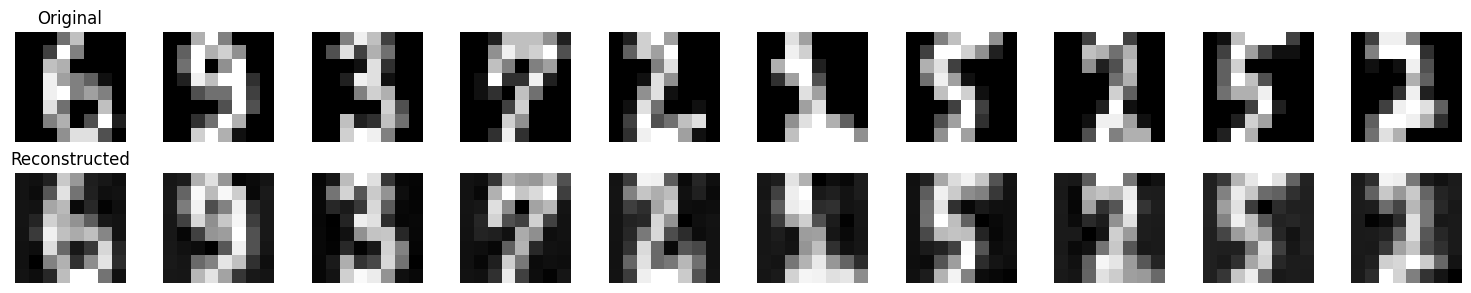


Prediction agreement between original and reconstructed: 94.72%


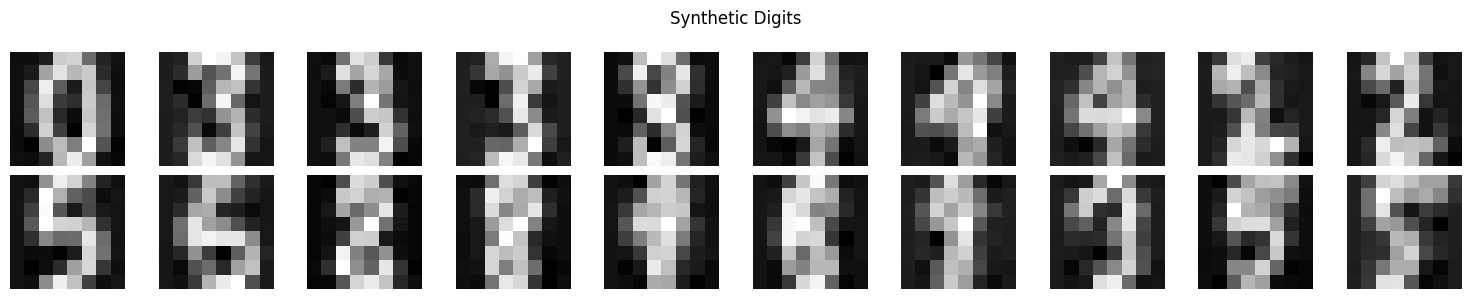


Predicted classes for synthetic digits: [0 3 3 3 8 4 4 4 2 2 5 6 8 8 1 8 8 9 5 5]


In [ ]:
run_bottleneck_experiments()

Comparison of the results of the autoencoder with bottleneck size 2, 4, and 8 on the digits dataset.

- The autoencoder with bottleneck size 8 has the least reconstruction error, followed by the autoencoder with bottleneck size 4 and 2.

- The autoencoder with bottleneck size 8 has the highest capacity to learn the data distribution and can reconstruct the data most accurately.

- The autoencoder with bottleneck size 2 has the lowest capacity to learn the data distribution and can reconstruct the data least accurately.

Although the autoencoder with bottleneck size 2 has the lowest capacity, it can still recognize the digit labels in the reconstructed data.

Generated synthetic digits are clear and recognizable, and the classifier performs well on the synthetic data.